In [ ]:
# install
%pip install vega_datasets
%pip install scipy
%pip insrall altair

In [300]:
#imports
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

import altair as alt
from vega_datasets import data

import numpy as np
from scipy.stats import pearsonr

import geopandas as gpd
import requests
import tempfile

## Data Setting & Methods

### 1.) Load in all datasets
- a.) TODO: brief description of datasets

### 2.) Clean each dataset
-  b.) TODO: before each method, add a brief description of how it's being cleaned

In [301]:
#load datasets
vaccinations = pd.read_csv("COVID-19_Vaccinations.csv", low_memory=False)
covid_cases = pd.read_csv("covid_confirmed_usafacts.csv", low_memory=False)
death_cases = pd.read_csv("covid_deaths_usafacts.csv", low_memory=False)
gdp_by_county = pd.read_csv("GDP by County.csv", low_memory=False)



In [302]:
def clean_gdp_by_county(df):
    # reformating
    # Drop rows where all cells are NaN
    df = df.iloc[1:]
    df = df.dropna(how='all')
    states = [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
        "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
        "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
        "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana",
        "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York",
        "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
        "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ]

    # Drop rows where the index (county) is actually a state name
    df = df[~df.index.isin(states)]
    df.set_index("County", inplace=True)
    return df
gdp_by_county = clean_gdp_by_county(gdp_by_county)


In [303]:
def clean_vax_df(df_vax):
    #clean vaccination dataset
    # Convert the 'Date' column to datetime format
    df_vax["Date"] = pd.to_datetime(df_vax["Date"], format="%m/%d/%Y")

    # Extract Year, Month, and Day
    df_vax["Year"] = df_vax["Date"].dt.year
    df_vax["Month"] = df_vax["Date"].dt.month
    df_vax["Day"] = df_vax["Date"].dt.day

    df_vax["Recip_County"] = df_vax["Recip_County"].str.replace(" County", "").str.strip()

    # Rename columns to match indexing convention
    df_vax = df_vax.rename(columns={"Recip_County": "County", "Recip_State": "State"})

    # Select only relevant columns
    df_vax = df_vax[["State", "County", "Year", "Month", "Day", "Series_Complete_Yes", 
                    "Series_Complete_Pop_Pct", "Booster_Doses_Vax_Pct"]]

    # Set the multi-index
    df_vax.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_vax

vaccinations = clean_vax_df(vaccinations)

In [304]:
def clean_cases_df(df_cases):
    # Standardize county names (remove " County")
    df_cases["County Name"] = df_cases["County Name"].str.replace(" County", "").str.strip()

    # Rename columns for consistency
    df_cases = df_cases.rename(columns={"County Name": "County", "State": "State"})

    # Drop unnecessary columns
    df_cases = df_cases.drop(columns=["countyFIPS", "StateFIPS"])

    # Convert wide format (dates as columns) to long format
    df_cases = df_cases.melt(id_vars=["State", "County"], var_name="Date", value_name="Cases")

    # Convert Date column to datetime and extract Year, Month, Day
    df_cases["Date"] = pd.to_datetime(df_cases["Date"])
    df_cases["Year"] = df_cases["Date"].dt.year
    df_cases["Month"] = df_cases["Date"].dt.month
    df_cases["Day"] = df_cases["Date"].dt.day


    # Drop the original Date column
    df_cases.drop(columns=["Date"], inplace=True)
    df_cases = df_cases[df_cases["County"] != "Statewide Unallocated"]

    # Set multi-index
    df_cases.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_cases
covid_cases = clean_cases_df(covid_cases)

In [305]:
def clean_deaths_df(df_deaths):
    '''
    TODO: Write Docstring
    '''
    # Drop unnecessary columns
    df_deaths = df_deaths.drop(columns=["StateFIPS"], errors="ignore")

    # Rename columns for consistency
    df_deaths = df_deaths.rename(columns={"County Name": "County", "State": "State", "countyFIPS":"FIPS"})

    # Standardize county names (remove "County" and extra spaces)
    df_deaths["County"] = df_deaths["County"].str.replace(" County", "").str.strip()

    # Remove rows where County is "Statewide Unallocated"
    df_deaths = df_deaths[df_deaths["County"] != "Statewide Unallocated"]

    # Reshape from wide format to long format
    df_deaths = df_deaths.melt(id_vars=["State", "County", "FIPS"], var_name="Date", value_name="Deaths")

    # Convert Date column to datetime format
    df_deaths["Date"] = pd.to_datetime(df_deaths["Date"], format="%Y-%m-%d")

    # Extract Year, Month, and Day
    df_deaths["Year"] = df_deaths["Date"].dt.year
    df_deaths["Month"] = df_deaths["Date"].dt.month
    df_deaths["Day"] = df_deaths["Date"].dt.day

    # Drop the original Date column
    df_deaths.drop(columns=["Date"], inplace = True)

    # Set multi-index
    df_deaths.set_index(["State", "County", "Year", "Month", "Day"], inplace=True)
    return df_deaths
death_cases = clean_deaths_df(death_cases)

In [265]:
def read_geojson():
    # URL for a pre-converted GeoJSON of U.S. counties
    geojson_url = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'

    # Download the GeoJSON file
    response = requests.get(geojson_url)
    response.raise_for_status()

    # Save to a temporary file
    with tempfile.NamedTemporaryFile(suffix=".json", delete=False) as tmp:
        tmp.write(response.content)
        tmp_filename = tmp.name

    # Read the GeoJSON with GeoPandas
    gdf_counties = gpd.read_file(tmp_filename)

    gdf_projected = gdf_counties.to_crs(epsg=5070)

    # Compute centroids in the projected CRS
    gdf_projected['centroid'] = gdf_projected.geometry.centroid

    # Reproject the centroids back to geographic coordinates (EPSG:4326) for Altair
    gdf_counties['centroid'] = gdf_projected['centroid'].to_crs(epsg=4326)

    # Extract longitude and latitude from the centroids
    gdf_counties['longitude'] = gdf_counties['centroid'].x
    gdf_counties['latitude'] = gdf_counties['centroid'].y

    gdf_counties['id'] = gdf_counties['id'].astype(int)
    
    return gdf_counties
gdf_counties = read_geojson()

In [306]:
def merge_datasets():
    '''
    TODO: Write Docstring
    '''

    #CHANGED FROM OUTER -> INNER
    df_combined = covid_cases.merge(death_cases, on=["State", "County", "Year", "Month", "Day"], how="inner")
    df_combined = df_combined.merge(vaccinations, on=["State", "County", "Year", "Month", "Day"], how="inner")
    
    #setup so we can merge on county
    df_combined = df_combined.reset_index()
    gdp_reset = gdp_by_county.reset_index()

    df_combined = pd.merge(df_combined, gdp_reset, on="County", how="left")
    df_combined = df_combined.set_index(["State", "County", "Year", "Month", "Day"])
    
    return df_combined
df_combined = merge_datasets()

In [308]:
def reformat_GDP(df):
    #turn gdp2x -> gdp column for a give year

    # # #TESTING W THIS -- too many rows
    df.dropna(how='all', inplace=True)

    gdp_columns = ['GDP_20', 'GDP_21', 'GDP_22', 'GDP_23']

    # # Remove commas if present and convert each column to an integer
    for col in gdp_columns:
        df[col] =  df[col].str.replace(',', '').astype(float)  

    df['GDP_GROWTH'] = (df['GDP_23'] - df['GDP_20']) / df['GDP_20']
    
    

    # Convert GDP to numeric if it's stored as strings with commas
    df['GDP'] = df['GDP'].str.replace(',', '').astype(float)   


    
    return df
reformat_GDP(df_combined) #diff ver. with less rows

AttributeError: Can only use .str accessor with string values!

### Results

In [310]:
def map_gdp():
    df = df_combined.reset_index()[["State", "County", "Year", "FIPS", "GDP_GROWTH"]]

    df.drop_duplicates(subset=['FIPS'], keep='last', inplace=True) #most recent values

    df['Year'] = df['Year'].astype(str)

    #display(df.dtypes)
    alt.data_transformers.disable_max_rows()

    # TopoJSON of US counties
    counties = alt.topo_feature(data.us_10m.url, 'counties')


    map_chart = (
        alt.Chart(counties)
        .mark_geoshape()
        .encode(
            color='GDP_GROWTH:Q',
            tooltip=['County:N', 'State:N', 'GDP_GROWTH:Q']
        )
        .transform_lookup(
            lookup='id',    # 'id' in the counties TopoJSON is the FIPS code
            from_=alt.LookupData(df, 'FIPS', ['GDP_GROWTH', 'Year', 'State', 'County']) #'County', 'State', 'GDP', 'Year'
        )
        # .transform_filter(year_select)
        .project(type='albersUsa')
        .properties(width=700, height=400, title="GDP Growth (2020-2023)")
        #.add_params(year_select)
    )
    display(map_chart) 

map_gdp()

alt.Chart(...)

In [311]:
# def death_vaxx_rates():
#     df_plot = df_combined.reset_index()
#     df_plot["Date"] = pd.to_datetime(df_plot[["Year", "Month", "Day"]])
#     fig, ax1 = plt.subplots(figsize=(10, 6))

#     sns.lineplot(data=df_plot, x="Date", y="Deaths", ax=ax1, color="red", label="Deaths")
#     ax1.set_ylabel("Deaths", color="red")

#     ax2 = ax1.twinx()
#     sns.lineplot(data=df_plot, x="Date", y="Series_Complete_Pop_Pct", ax=ax2, color="green", label="Vaccination %")
#     ax2.set_ylabel("Vaccination %", color="green")

#     plt.title("Deaths vs Vaccination Rate Over Time")
#     plt.xlabel("Date")
#     plt.tight_layout()
#     plt.show()
# death_vaxx_rates()

### RQ.1 How did COVID vaccination rates correlate with fatality rates across different counties?

In [287]:
def fatality_vax_county():
    df = df_combined.reset_index()[["State", "County", "Year", "FIPS", "Series_Complete_Pop_Pct", "Deaths", "Cases"]]
    df['Fatality'] = df['Deaths'] / df['Cases']

    df['Year'] = df['Year'].astype(str)
    df.drop_duplicates(subset=['FIPS'], keep='last', inplace=True) #most recent


    counties = alt.topo_feature(data.us_10m.url, 'counties')
    choropleth = (
        alt.Chart(counties)
        .mark_geoshape()
        .encode(
            color=alt.Color('Fatality:Q', scale=alt.Scale(scheme='reds')),
            tooltip=[
                alt.Tooltip('County:N', title="County Name"),
                alt.Tooltip('State:N', title="State Name"),
                alt.Tooltip('Fatality:Q', title="Fatality Rate"),
                alt.Tooltip('Series_Complete_Pop_Pct:Q', title="Vaccination %"),
            ]
        )
        .transform_lookup(
            lookup='id',    # 'id' in the counties TopoJSON is the FIPS code
            from_=alt.LookupData(df, 'FIPS', ['State', 'County', 'Fatality', 'Series_Complete_Pop_Pct']) #'County', 'State', 'GDP', 'Year'
        )
        .project(type='albersUsa')
        .properties(width=700, height=400, title="Fatality Rate & Vaccination % per County")
    )

    gdf_counties.drop(columns=['STATE', 'COUNTY', 'NAME', 'LSAD'], inplace=True) #run once
    df = df.merge(gdf_counties, left_on='FIPS', right_on='id', how='inner')
    df.drop(columns=['id'], inplace=True)

    toggle = alt.param(
        name='showCircles',
        value=True,
        bind=alt.binding_checkbox(name='Show Vaccination %')
    )

    df_centroids = pd.DataFrame({
        'longitude': df['longitude'],
        'latitude': df['latitude'],
        'vax_rate': df['Series_Complete_Pop_Pct'],
        'name': df['County']        
    })

    # Create the circles layer where the circle size represents the vaccination rate.
    circles = (
        alt.Chart(df_centroids)
        .mark_circle(
        ).encode(
            longitude='longitude:Q',
            latitude='latitude:Q',
            size=alt.Size('vax_rate:Q',
                        scale=alt.Scale(range=[0, 100]),  # adjust the range as needed
                        title='Vaccination Rate'),
            tooltip=[
                alt.Tooltip('name:N', title='County'),
                alt.Tooltip('vax_rate:Q', title='Vaccination %')
            ]
        ).project(type='albersUsa')
        .add_params(toggle)
        .transform_filter(toggle) 
    )
    
    
    # display(choropleth) 
    # display(circles)
    display(choropleth + circles)
fatality_vax_county()

alt.LayerChart(...)

#### RQ.1 Cont.


### RQ.2 Is there a geographical trend for getting the complete vaccination series?

### RQ.3 Did the distribution of vaccines correlate with the # of covid cases and deaths?


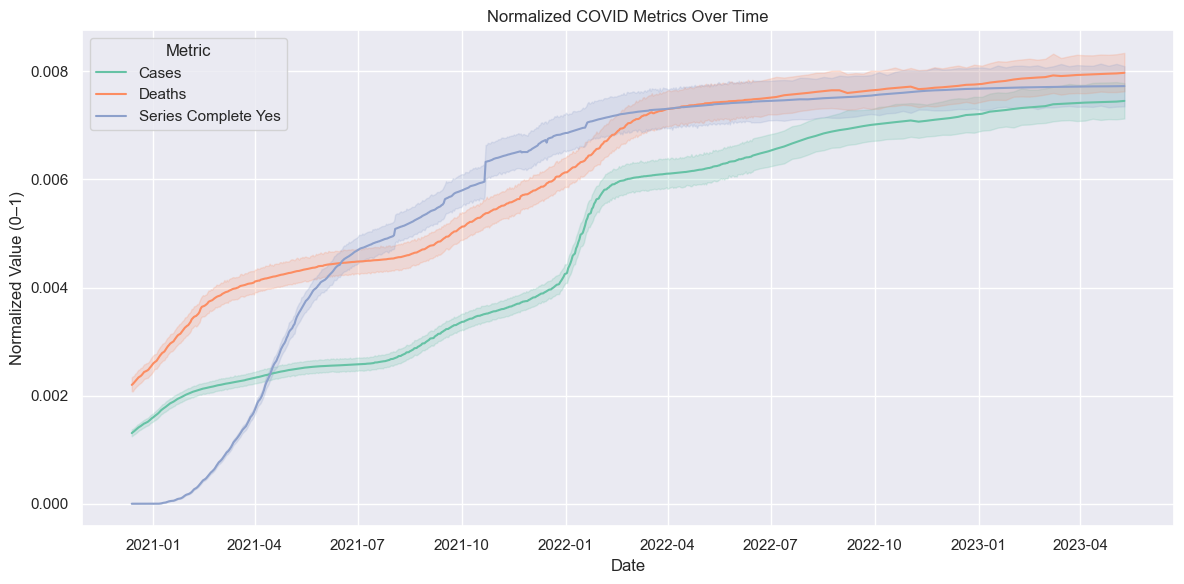

In [231]:
def normalized_time():
    df_plot = df_combined.reset_index()
    df_plot["Date"] = pd.to_datetime(df_plot[["Year", "Month", "Day"]])
    df_research_question_3 = df_plot.copy()

    metrics = ["Cases", "Deaths", "Series_Complete_Yes"]

    for col in metrics:
        df_research_question_3[col + "_norm"] = (df_research_question_3[col] - df_research_question_3[col].min()) / (df_research_question_3[col].max() - df_research_question_3[col].min())

    df_melted = df_research_question_3.melt( id_vars=["Date"], value_vars=[col + "_norm" for col in metrics], var_name="Metric",
        value_name="Normalized Value"
    )

    df_melted["Metric"] = df_melted["Metric"].str.replace("_norm", "").str.replace("_", " ")

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_melted, x="Date", y="Normalized Value", hue="Metric", palette="Set2")
    plt.title("Normalized COVID Metrics Over Time")
    plt.xlabel("Date")
    plt.ylabel("Normalized Value (0–1)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### RQ.3 Cont.